In [1]:
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In O:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In O:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In O:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In O:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In O:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
def x_cord_contour(contour):
    M = cv2.moments(contour)
    return (int(M['m10']/M['m00']))

# 여기서부터 세로 인식 (폴더 돌면서)

In [10]:
# score : 11자 중에 몇 개 맞았는지 = (맞은 글자 수)/11자 
def getAccuracy(text, filename):
    score = 0
    filename_list = list(filename)

    for i in range(0,len(text)):
        if(text[i:i+1] in filename_list): 
            filename_list.remove(text[i:i+1])
            score += 1
    
    return score

def getRecognitionAccuracy_vertical(subtype):
    
    folder_vertical = r"C:\MiniProject_Group3-main\CargoContainerImages" + subtype
    config = '-l eng --oem {} --psm {} tessedit_char_whitelist="{}" '

    score_accuracy_sum = 0
    perfect_cnt = 0
    total_cnt = 0
    threshold1 = 0
    zero_cnt = 0
    
    for filename in os.listdir(folder_vertical):
        if filename.upper().endswith(".JPG") or filename.upper().endswith(".JPEG") or filename.upper().endswith(".PNG"):       
            print("\nProcessing", filename)
            fullpath = os.path.join(folder_vertical, filename)
            
            custom_config = config.format(3, 6, 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')  #세로는 psm 6
            
#             image = cv2.imread(fullpath)
#             gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#             text = pytesseract.image_to_string(image, config=custom_config)   #fullpath

            text = preprocessing(fullpath)
            text = text.replace(" ", "")
            result_text = ""
            for c in text:
                if c.isalnum():
                    result_text += c
            text = result_text
            print(text)

            if len(text) > 0:
                if filename.find('_') >  -1:
                    filenameExceptJpg = filename[:filename.find('_')]
                else:
                    filenameExceptJpg = filename[:filename.find('.')]

                score = getAccuracy(text, filenameExceptJpg.upper())
                total_cnt += 1
                score_accuracy_sum += score/11
                print("score:", score, ", accuracy:", score/11)

                if score/11 == 1:
                    perfect_cnt += 1
                if score/11 > 0.7:
                    threshold1 += 1
                if score == 0:
                    zero_cnt += 1
        else:                               
            print("Ignoring", filename)
    
    print("\nsubtype", subtype[1:])
    print("accuracy_avg:", score_accuracy_sum/total_cnt, 
          ", perfect_cnt:", perfect_cnt, "/", total_cnt, 
          ", threshold1:", threshold1)
    print("except_zero_cnt:", total_cnt-zero_cnt,
          ", except_zero:", score_accuracy_sum/(total_cnt-zero_cnt))

In [17]:
# DLSU5002635_2
# SEGU4806170.PNG

def preprocessing(path):
    image = cv2.imread(path)
    #image = cv2.imread('CargoContainerImages/CAIU2728316.jpg')
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edged = cv2.Canny(blurred, 30, 150)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Sort out contours left to right by using their x cordinates
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 10]
    contours = sorted(filtered_contours, key = x_cord_contour, reverse = False)
    # Create empty array to store entire number
    full_number = []

#     plt.imshow(blurred)
#     plt.show()

    pad = 8
    total_width = 0
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)    
        total_width += w + pad

    contours = sorted(contours, key = lambda c: cv2.boundingRect(c)[1])
    all_im = np.zeros([200, total_width + 264], dtype=np.uint8) ##height 모자라는 거 같아서 80->100

    offset = 24
#     print('boundaries....')
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)   
        #print(x, y, w, h)
        if w >= 0 and h >=0:
            roi = blurred[y:y + h, x:x + w]
            final = roi
#             print(roi.shape)
#             print('all_im size: ', h, w)
            try:
                all_im[16:h + 16, offset:offset + w] = roi
            
            except:
                continue
            
            offset += w + pad
            #print(x, y, x+w, y+h)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    all_im[all_im < 127] = 0
    scale = 0.5
    all_im = cv2.resize(all_im, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    
    # 최종 이미지 -> 주석처리
    plt.imshow(all_im)
    plt.show()
    
    config = '-l eng --oem 3 --psm 8 tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTU0123456789" '
    print('tesseract ocr result: ', pytesseract.image_to_string(all_im, config=config))
    text = pytesseract.image_to_string(all_im, config=config)
    
    return text


Processing BMOU4699433.jpg


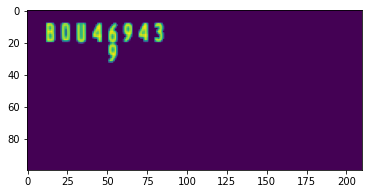

tesseract ocr result:  on

on
score: 0 , accuracy: 0.0

Processing BMOU5782049.jpg


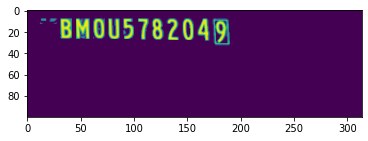

tesseract ocr result:  “ae

ae
score: 0 , accuracy: 0.0

Processing BSIU2575064.jpg


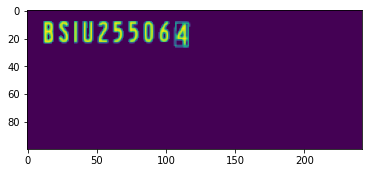

tesseract ocr result:  _—



Processing CAIU2728316.jpg


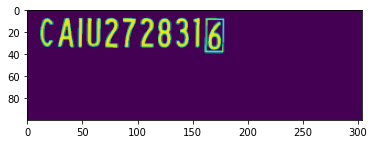

tesseract ocr result:  ore

ore
score: 0 , accuracy: 0.0

Processing CAIU4051570.jpg


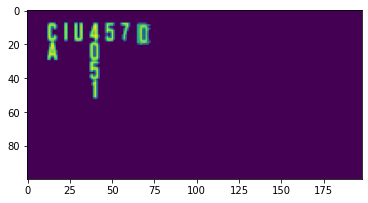

tesseract ocr result:  vo

vo
score: 0 , accuracy: 0.0

Processing CAIU8121016.jpg


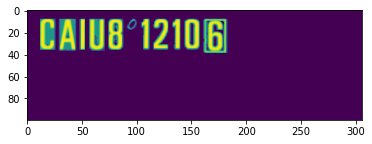

tesseract ocr result:  mee

mee
score: 0 , accuracy: 0.0

Processing CARU3858347.jpg


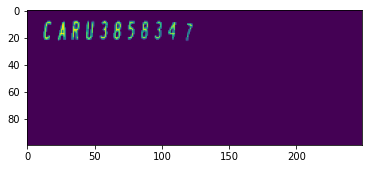

tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing CAXU8004650.jpg


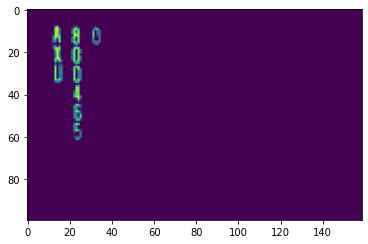

tesseract ocr result:  yo

yo
score: 0 , accuracy: 0.0

Processing CBXU2785862.jpg


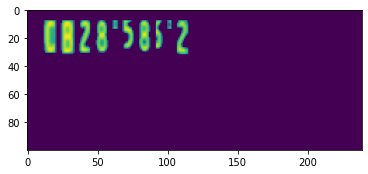

tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing CMAU5349828.jpg


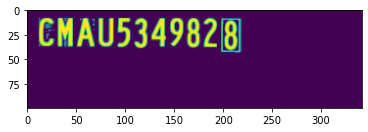

tesseract ocr result:  in

in
score: 0 , accuracy: 0.0

Processing CPIU1762554.jpg


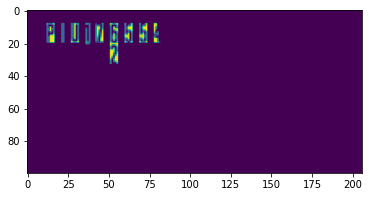

tesseract ocr result:  ae

ae
score: 0 , accuracy: 0.0

Processing CPIU1762554_2.jpg


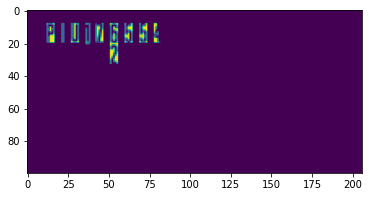

tesseract ocr result:  ae

ae
score: 0 , accuracy: 0.0

Processing CRXU1525331.jpg


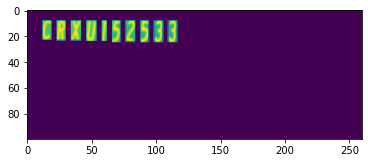

tesseract ocr result:  om

om
score: 0 , accuracy: 0.0

Processing DFSU7696722.jpg


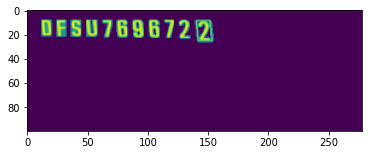

tesseract ocr result:  “



Processing DFSU7696722_2.jpg


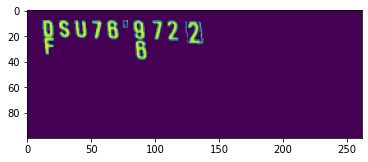

tesseract ocr result:  wv

wv
score: 0 , accuracy: 0.0

Processing DFSU7697586.jpg


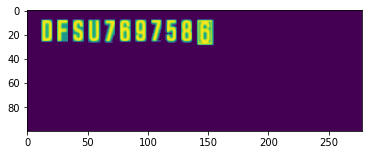

tesseract ocr result:  “_



Processing DLSU5000210.JPG


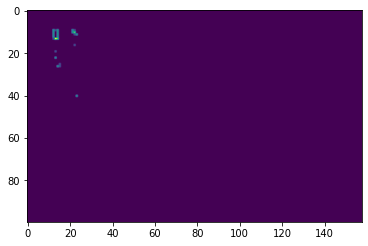

tesseract ocr result:  a

a
score: 0 , accuracy: 0.0

Processing DLSU5001789.jpg


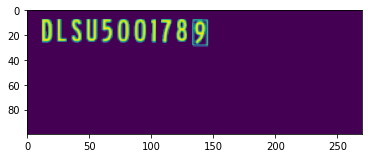

tesseract ocr result:  ov

ov
score: 0 , accuracy: 0.0

Processing DLSU5002635.jpg


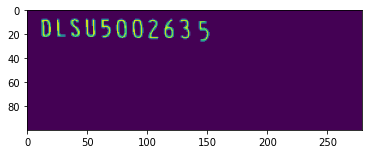

tesseract ocr result:  a

a
score: 0 , accuracy: 0.0

Processing DLSU5002635_2.jpg


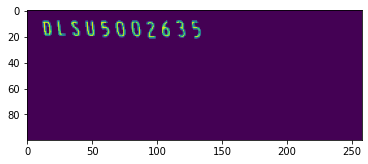

tesseract ocr result:  ne

ne
score: 0 , accuracy: 0.0

Processing DRTU9735030.JPG


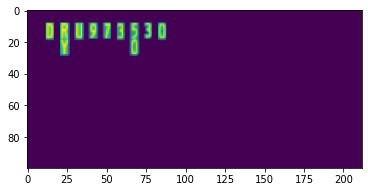

tesseract ocr result:  _



Processing DRYU2007060.jpg


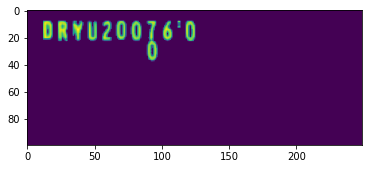

tesseract ocr result:  _—



Processing DRYU9393792.jpg


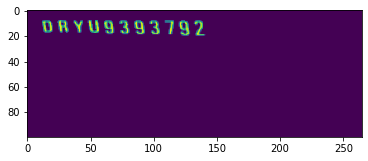

tesseract ocr result:  —



Processing DRYU9735030.jpg


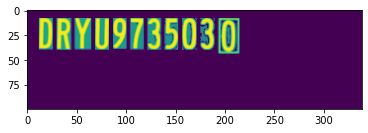

tesseract ocr result:  30

30
score: 2 , accuracy: 0.18181818181818182

Processing ECMU9906919.jpg


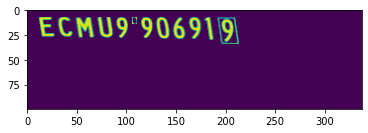

tesseract ocr result:  ene

ene
score: 0 , accuracy: 0.0

Processing FBLU0160104.jpg


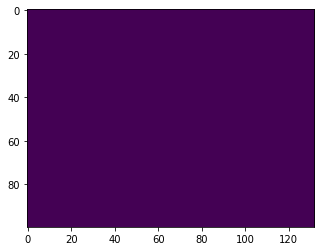

tesseract ocr result:  a

a
score: 0 , accuracy: 0.0

Processing FBXU0220812.jpg


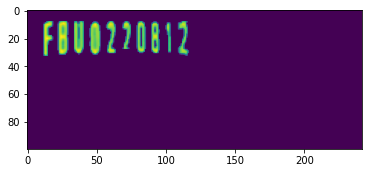

tesseract ocr result:  “um

um
score: 0 , accuracy: 0.0

Processing FCBU8608136.jpg


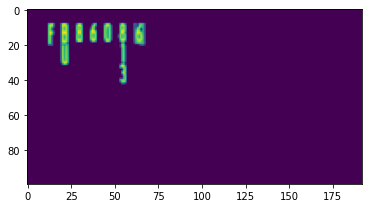

tesseract ocr result:  mu

mu
score: 0 , accuracy: 0.0

Processing FCIU2246272.jpg


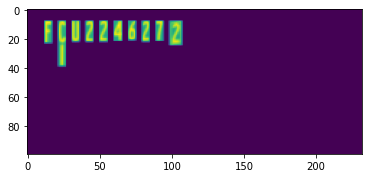

tesseract ocr result:  on

on
score: 0 , accuracy: 0.0

Processing FSCU9954987.jpg


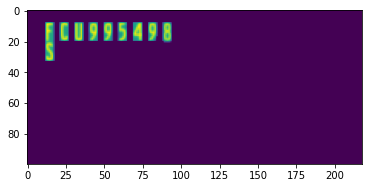

tesseract ocr result:  a

a
score: 0 , accuracy: 0.0

Processing FXLU8425651.jpg


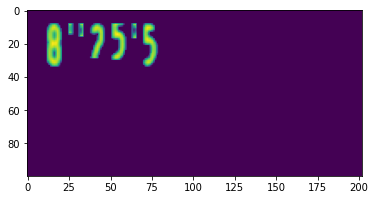

tesseract ocr result:  me

me
score: 0 , accuracy: 0.0

Processing GLDU2212400.jpg


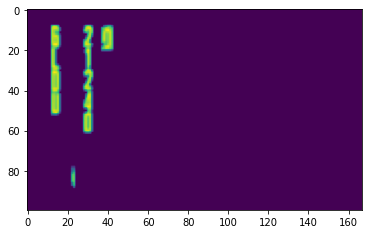

tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing GLDU2940129.jpg


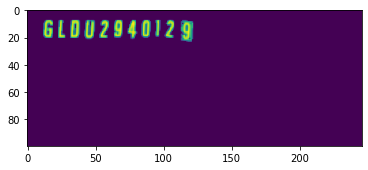

tesseract ocr result:  wn

wn
score: 0 , accuracy: 0.0

Processing GLDU3075112.jpg


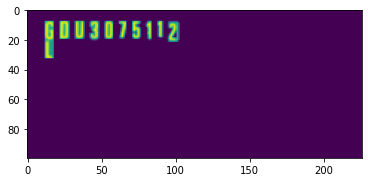

tesseract ocr result:  _



Processing GLDU7542431_2.jpg


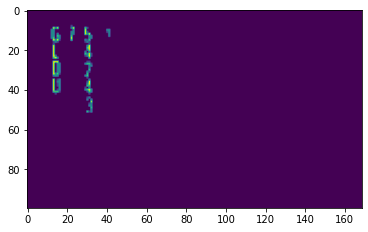

tesseract ocr result:  yo

yo
score: 0 , accuracy: 0.0

Processing GMTU9007865.jpg


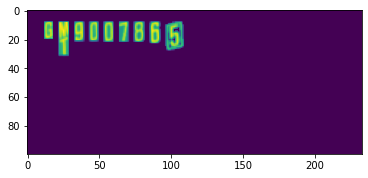

tesseract ocr result:  ov

ov
score: 0 , accuracy: 0.0

Processing GVCU2129062.jpg


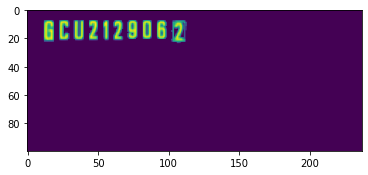

tesseract ocr result:  ov

ov
score: 0 , accuracy: 0.0

Processing HDMU2490784.jpg


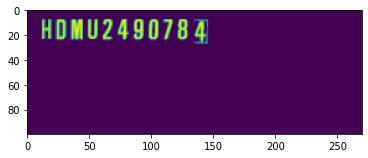

tesseract ocr result:  _v

v
score: 0 , accuracy: 0.0

Processing HPCU4006609.jpg


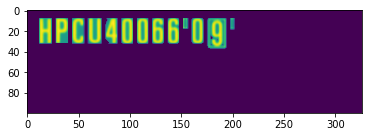

tesseract ocr result:  ne

ne
score: 0 , accuracy: 0.0

Processing JTAU7000027_vertical.jpg


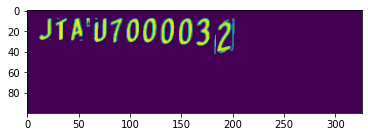

tesseract ocr result:  aie

aie
score: 0 , accuracy: 0.0

Processing KDCU2153791.jpg


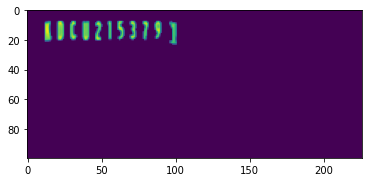

tesseract ocr result:  ne

ne
score: 0 , accuracy: 0.0

Processing KDCU5140801.jpg


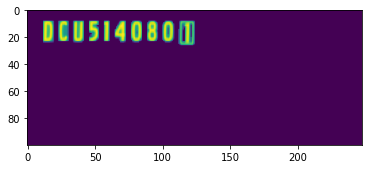

tesseract ocr result:  _v

v
score: 0 , accuracy: 0.0

Processing LCRU0113648.jpg


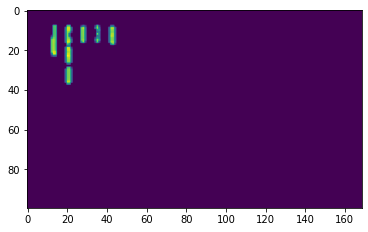

tesseract ocr result:  no

no
score: 0 , accuracy: 0.0

Processing MTBU2033374.jpg


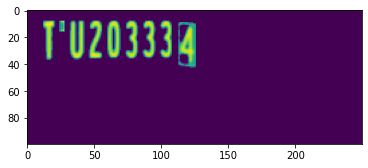

tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing MTBU2070974.jpg


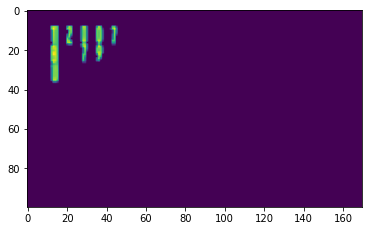

tesseract ocr result:  mo

mo
score: 0 , accuracy: 0.0

Processing MWLU2480214.jpg


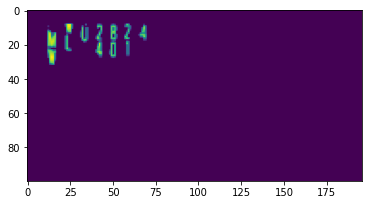

tesseract ocr result:  a

a
score: 0 , accuracy: 0.0

Processing MWLU2481210.jpg


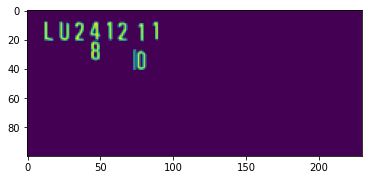

tesseract ocr result:  oe

oe
score: 0 , accuracy: 0.0

Processing SCTU0017000.jpg


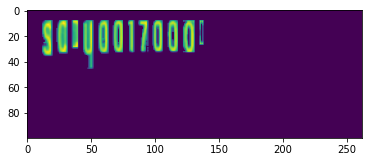

tesseract ocr result:  “oun

oun
score: 0 , accuracy: 0.0

Processing SEGU4806170.PNG


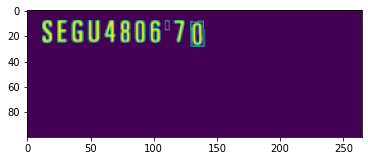

tesseract ocr result:  “ve

ve
score: 0 , accuracy: 0.0

Processing TCKU9269809.jpg


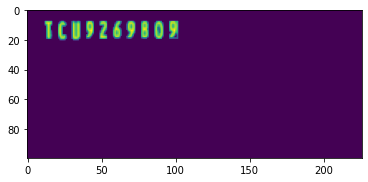

tesseract ocr result:  ae

ae
score: 0 , accuracy: 0.0

Processing TCNU6103721.jpg


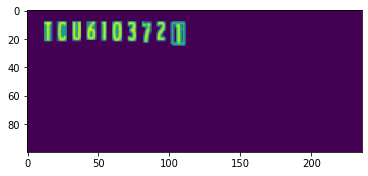

tesseract ocr result:  “ew

ew
score: 0 , accuracy: 0.0

Processing TCNU6120328.jpg


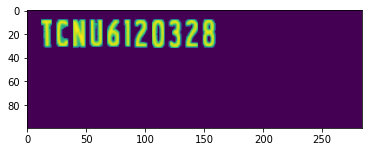

tesseract ocr result:  me

me
score: 0 , accuracy: 0.0

Processing TEMU6308819.jpg


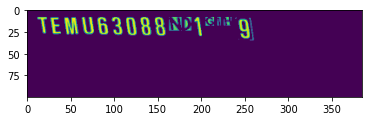

tesseract ocr result:  re

re
score: 0 , accuracy: 0.0

Processing TEMU6971077.jpg


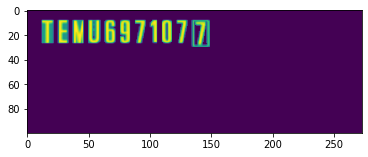

tesseract ocr result:  “oe

oe
score: 0 , accuracy: 0.0

Processing TEXU4521496.JPG


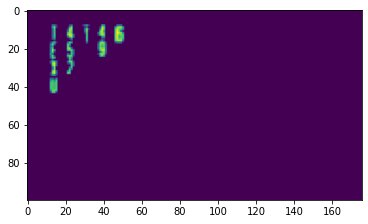

tesseract ocr result:  ue

ue
score: 0 , accuracy: 0.0

Processing TGHU0709122.jpg


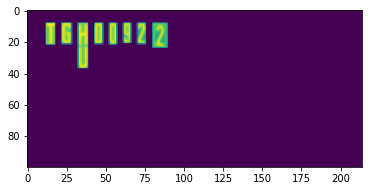

tesseract ocr result:  “



Processing TGHU0930956.jpg


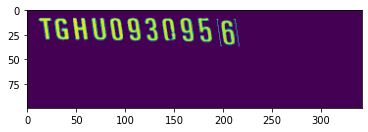

tesseract ocr result:  mee

mee
score: 0 , accuracy: 0.0

Processing TGHU9343311.JPG


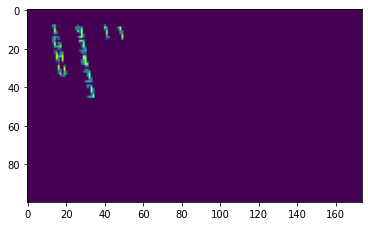

tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing TGHU9363600.jpg


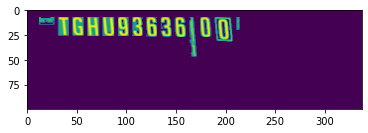

tesseract ocr result:  —



Processing TGHU9461926.jpg


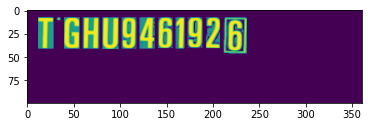

tesseract ocr result:  ae

ae
score: 0 , accuracy: 0.0

Processing VICU5000230.jpg


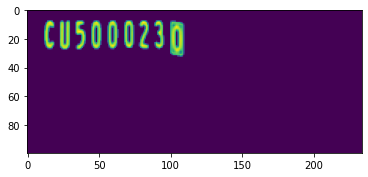

tesseract ocr result:  om

om
score: 0 , accuracy: 0.0

Processing WSCU9161321.jpg


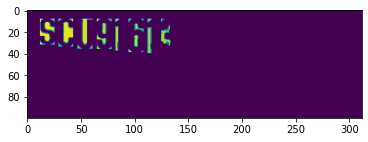

tesseract ocr result:  ae

ae
score: 0 , accuracy: 0.0

subtype vertical
accuracy_avg: 0.003430531732418525 , perfect_cnt: 0 / 53 , threshold1: 0
except_zero_cnt: 1 , except_zero: 0.18181818181818182


In [18]:
subtype = r"\vertical"  # horizontal(1) or vertical(2)
getRecognitionAccuracy_vertical(subtype)

# Horizontal 은 그냥 해본 것

In [14]:
subtype = r"\horizontal"  # horizontal(1) or vertical(2)
getRecognitionAccuracy_vertical(subtype)


Processing BBCU2008169.jpg
tesseract ocr result:  ee

ee
score: 0 , accuracy: 0.0

Processing BHCU2088072.jpg
tesseract ocr result:  PBs

PBs
score: 1 , accuracy: 0.09090909090909091

Processing BHCU3088072.jpg
tesseract ocr result:  ae

ae
score: 0 , accuracy: 0.0

Processing CAIU2191783.jpg
tesseract ocr result:  Sresieae

Sresieae
score: 0 , accuracy: 0.0

Processing CBCU2000317.jpg
tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing CCLU1026613.jpg
tesseract ocr result:  ee

ee
score: 0 , accuracy: 0.0

Processing CCLU2058301.jpg
tesseract ocr result:  ue

ue
score: 0 , accuracy: 0.0

Processing CCLU4755619.jpg
tesseract ocr result:  oe

oe
score: 0 , accuracy: 0.0

Processing CCLU4856213.jpg
tesseract ocr result:  an

an
score: 0 , accuracy: 0.0

Processing CICU9679964.jpg
tesseract ocr result:  oe

oe
score: 0 , accuracy: 0.0

Processing CICU9679964_2.jpg
tesseract ocr result:  oe

oe
score: 0 , accuracy: 0.0

Processing CICU9728204.jpg
tesseract ocr re